In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from cmocean import cm
from matplotlib.colors import LinearSegmentedColormap
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
import scipy.stats as st
from scipy.interpolate import interp1d
from scipy import arange, array, exp, integrate
from physoce import tseries as ts
import gsw

def neureg(x,y):
    #x,y are numpy arrays
    #subtract mean to make zero mean:
    xn = x - np.mean(x)
    yn = y - np.mean(y)
    #perform neutral regression for comparison, e.g. Garrett and Petrie 1981 and Kirincich et al 2005
    an = np.sqrt(((st.tvar(yn)))/((st.tvar(xn)))) #find slope
    bn = (np.mean(y) - an*np.mean(x)) #find intercept
    rn = np.sum(x*y)/np.sqrt((np.sum(x**2)*np.sum(y**2))) #find correlation coefficient
    slope_err = an*np.sqrt((1-rn**2)/len(x)) #compute std err in slope = a*sqrt((1-r^2)/n)
    #compute std err in intercept = vary^.5*sqrt((1-r^2)/n*(1+xmean^2/var(x))) 
    #(e.g., Miller & Kahn 1962, Statistical Analysis in the Geological Science)
    #https://stats.stackexchange.com/questions/391112/standard-error-of-coefficient-estimates-for-model-ii-regression
    inter_err = np.sqrt(st.tvar(yn))*np.sqrt(((1-rn**2)/len(x))*(1+np.mean(x)**2/st.tvar(xn))) 
    return an,bn,rn,slope_err,inter_err

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


# Data Retrieval and Preparation

*Velocity data should be from adcp boudary analysis, not online source!*

In [40]:
ds = xr.open_dataset('C:/Users/asche/REU21/netcdf/inshore_surface_adcp_comb_linear2.nc')
zero = np.zeros(len(ds['time']))

In [41]:
ncfile_prof = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered/deployment0013_CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered.ncml'
ds_no3 = xr.open_dataset(ncfile_prof+'#fillmismatch')

In [42]:
ds_no3.load()

<xarray.Dataset>
Dimensions:                                 (obs: 14288, wavelength: 256)
Coordinates:
  * wavelength                              (wavelength) int32 0 1 2 ... 254 255
  * obs                                     (obs) int32 0 1 2 ... 14286 14287
    time                                    (obs) datetime64[ns] 2019-05-29T1...
    pressure                                (obs) float64 18.85 18.71 ... 0.9342
    lat                                     (obs) float64 44.66 44.66 ... 44.66
    lon                                     (obs) float64 -124.1 ... -124.1
Data variables: (12/56)
    profiler_timestamp                      (obs) datetime64[ns] 2019-05-29T1...
    nutnr_spectrum_average                  (obs) float32 1.82e+04 ... 1.708e+04
    nutnr_fit_base_2                        (obs) float32 -1.738 -1.552 ... -2.3
    nutnr_fit_base_1                        (obs) float32 5.111 4.71 ... 9.646
    year                                    (obs) float32 2.019e+03 ... 2.019...
    ctd_psu                                 (obs) float32 -1.0 -1.0 ... -1.0
    ...                                      ...
    ctd_temp_qc_results                     (obs) float32 1.0 1.0 ... 1.0 1.0
    ctd_dbar_qc_executed                    (obs) float32 1.0 1.0 ... 1.0 1.0
    ctd_dbar_qc_results                     (obs) float32 0.0 0.0 ... 0.0 0.0
    salinity_corrected_nitrate_qc_executed  (obs) float32 29.0 29.0 ... 29.0
    salinity_corrected_nitrate_qc_results   (obs) float32 13.0 13.0 ... 29.0
    spectral_channels                       (obs, wavelength) float32 593.0 ....
Attributes: (12/70)
    node:                               SP001
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             nutnr_j_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    DODS.strlen:                        18
    DODS.dimName:                       string18

In [43]:
ds.load()

<xarray.Dataset>
Dimensions:           (bin_depths_avg: 22, time: 2235)
Coordinates:
  * time              (time) datetime64[ns] 2019-04-20T03:30:00 ... 2019-10-2...
  * bin_depths_avg    (bin_depths_avg) float64 -21.98 -20.98 ... -1.98 -0.9797
Data variables: (12/17)
    u                 (bin_depths_avg, time) float64 0.0781 0.1144 ... 1.195
    v                 (bin_depths_avg, time) float64 0.08675 0.1102 ... -0.2696
    sea_surface       (time) float64 -1.069 -0.4755 0.8208 ... 0.5014 0.2247
    bottom_depth_avg  float64 24.08
    u_fil             (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    v_fil             (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    ...                ...
    as_fil            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    theta             float64 80.67
    cs_bar            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    as_bar            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    us_comb           (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    zs_comb           (time) float64 nan nan nan nan nan ... nan nan nan nan nan

In [44]:
ds_no3 = ds_no3.swap_dims({'obs':'time'})

In [301]:
depth = np.flip(-ds['bin_depths_avg'].values)
cs_bar = np.flip(ds['cs_bar'].values, axis=0)
time_grid = ds['time'].values   # array of dates

# Bin Nitrate Data

## Begin with time and pressure grids based on velocity data

In [302]:
dp = 1   # pressure averaging interval
# center of pressure bins, assumes depth=pressure in dbar
pressure_grid = np.flip(-ds['bin_depths_avg'].values) 
# edges of pressure bins
pressure_bins = np.zeros(len(pressure_grid)+1) 
# handle ends of edges of bins first:
pressure_bins[0] = pressure_grid[0] - dp/2
pressure_bins[-1] = pressure_grid[-1] + dp/2
#now find the middle of interior bins based on velocity dataset
for i in range(len(pressure_bins)-2):
    pressure_bins[i+1] = np.average([pressure_grid[i],pressure_grid[i+1]])

### Ensure bins are correct

In [303]:
-ds['bin_depths_avg']

<xarray.DataArray 'bin_depths_avg' (bin_depths_avg: 22)>
array([21.97974168, 20.97974168, 19.97974168, 18.97974168, 17.97974168,
       16.97974168, 15.97974168, 14.97974168, 13.97974168, 12.97974168,
       11.97974168, 10.97974168,  9.97974168,  8.97974168,  7.97974168,
        6.97974168,  5.97974168,  4.97974168,  3.97974168,  2.97974168,
        1.97974168,  0.97974168])
Coordinates:
  * bin_depths_avg  (bin_depths_avg) float64 -21.98 -20.98 ... -1.98 -0.9797

In [304]:
pressure_grid

array([ 0.97974168,  1.97974168,  2.97974168,  3.97974168,  4.97974168,
        5.97974168,  6.97974168,  7.97974168,  8.97974168,  9.97974168,
       10.97974168, 11.97974168, 12.97974168, 13.97974168, 14.97974168,
       15.97974168, 16.97974168, 17.97974168, 18.97974168, 19.97974168,
       20.97974168, 21.97974168])

In [305]:
pressure_bins

array([ 0.47974168,  1.47974168,  2.47974168,  3.47974168,  4.47974168,
        5.47974168,  6.47974168,  7.47974168,  8.47974168,  9.47974168,
       10.47974168, 11.47974168, 12.47974168, 13.47974168, 14.47974168,
       15.47974168, 16.47974168, 17.47974168, 18.47974168, 19.47974168,
       20.47974168, 21.47974168, 22.47974168])

In [306]:
# pre-allocate gridded variable with NaNs
#temperature_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)])
nitrate_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)])

## Perform Binning

In [489]:
for i,t in enumerate(time_grid):
    try:
        ## find dates that fall in interval, ignores final time stamp
        ti, = np.where((ds_no3['time'] >= time_grid[i]) & (ds_no3['time'] < time_grid[i+1]))
        nitrate_subset = ds_no3['nitrate_concentration'].isel(time=ti) 
        #print(t)
        #print(ti)
        nitrate_binned = nitrate_subset.groupby_bins('pressure',pressure_bins).mean()
        nitrate_grid[i,:] = nitrate_binned.values
    except:
        pass

### If bin is in bottom layer, perform nearest neighbor extrap

In [490]:
bottom_layer_bins = len(nitrate_grid.T) #how many bins to include in bottom layer

In [491]:
nitrate_grid

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
for i,nd in enumerate(nitrate_grid.T[-bottom_layer_bins:]):     
    for j,nt in enumerate(nd):
        #print(nt)
        if np.isnan(nitrate_grid.T[-bottom_layer_bins+i+1][j]) and ~np.isnan(nt):
            if -bottom_layer_bins+i+1 == 0: #skip bottom bin
                pass
            else:
                nitrate_grid.T[-bottom_layer_bins+i+1][j] = nt

In [493]:
nitrate_grid.T[10][552]

nan

In [494]:
nitrate_grid.T[11][552]

nan

# Calculate Nitrate Flux from Velocity and Nitrate Data

In [495]:
print(time_grid[722])

2019-06-18T18:30:00.000000000


In [496]:
pressure_grid[6]

6.979741679276053

In [497]:
nitrate_grid[722][8]

33.99150085449219

In [498]:
#empty array for nitrate flux data
nflux = np.nan*np.empty([len(nitrate_grid),len(nitrate_grid.T)])

#rectangle widths for riemann sum
dz = np.nan*np.empty(len(pressure_grid))
for i,pg in enumerate(pressure_grid):
    dz[i] = pressure_bins[i+1] - pressure_bins[i] #find height of each bin
dz

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

## Find Nitrate Flux

*Nitrate flux is calculated as Riemann sum of velocity times nitrate concentration, over depths of pressure bins in nitrate/velocity data. Riemann sum is taken as the left endpoint rectangular approximation, e.g.* 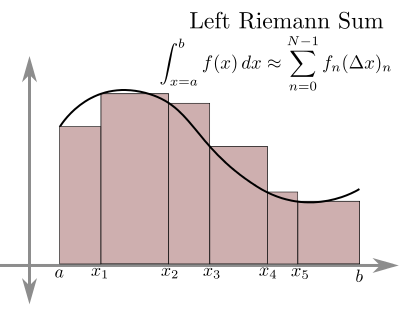

In [499]:
for i in range(len(nitrate_grid)):
    for j in range(len(nitrate_grid.T)):
        #leave nan values as nan in case they do not match up b/t cs and nit
        #if not np.isnan(nitrate_grid[i][j]) & np.isnan(cs_bar[i][j]):
            #nitrate flux in mmol/s/meter coastline
        nflux[i][j] = nitrate_grid[i][j] * cs_bar[j][i] * dz[j]
        

# Plot data

In [500]:
mask = ~np.isnan(nitrate_grid.T)
zeros = np.zeros(len(time_grid))
t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-01 00:00:00')

In [501]:
cs = ds['cs_bar'].values
vel_mask = ~np.isnan(cs)

## Nitrate flux and concentration at different depths 

Text(0, 0.5, 'Nitrate Concentration [$mmol/m^2/100m$]')

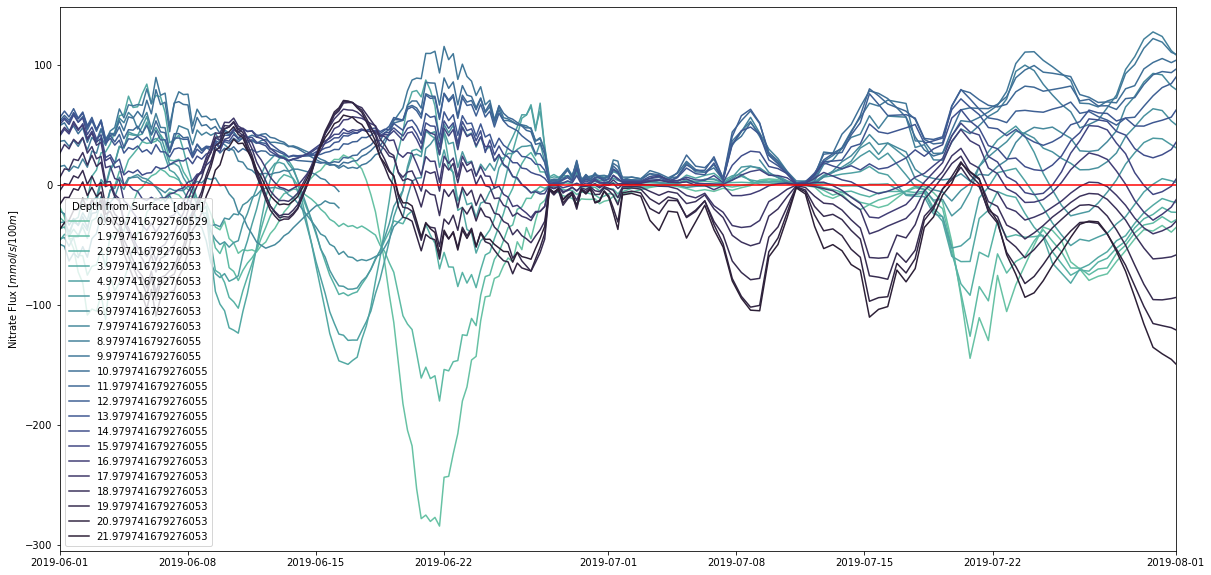

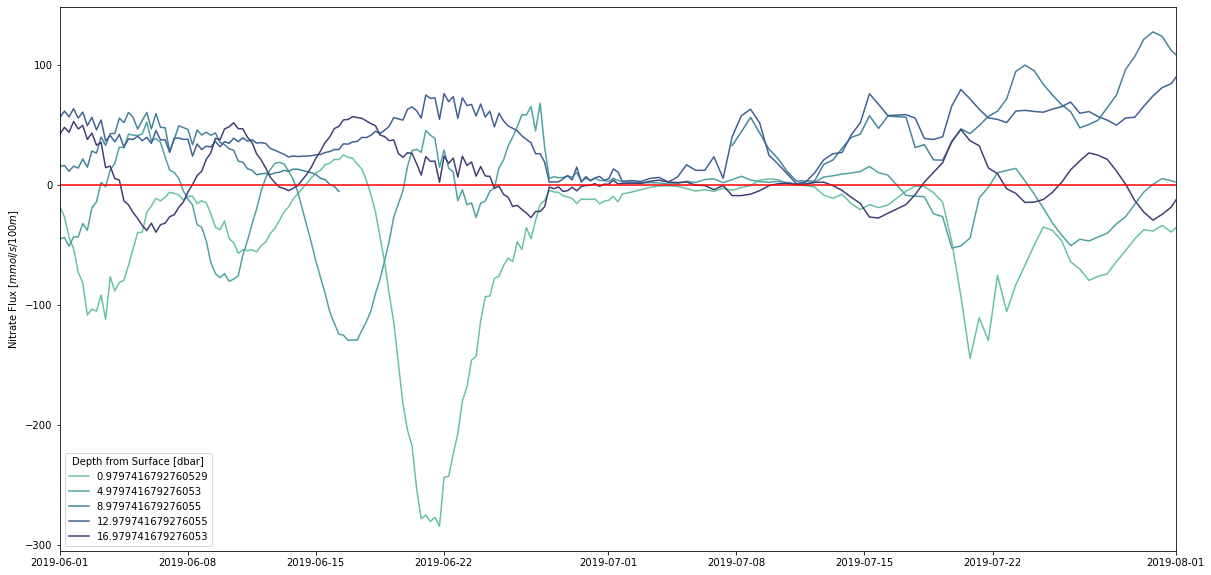

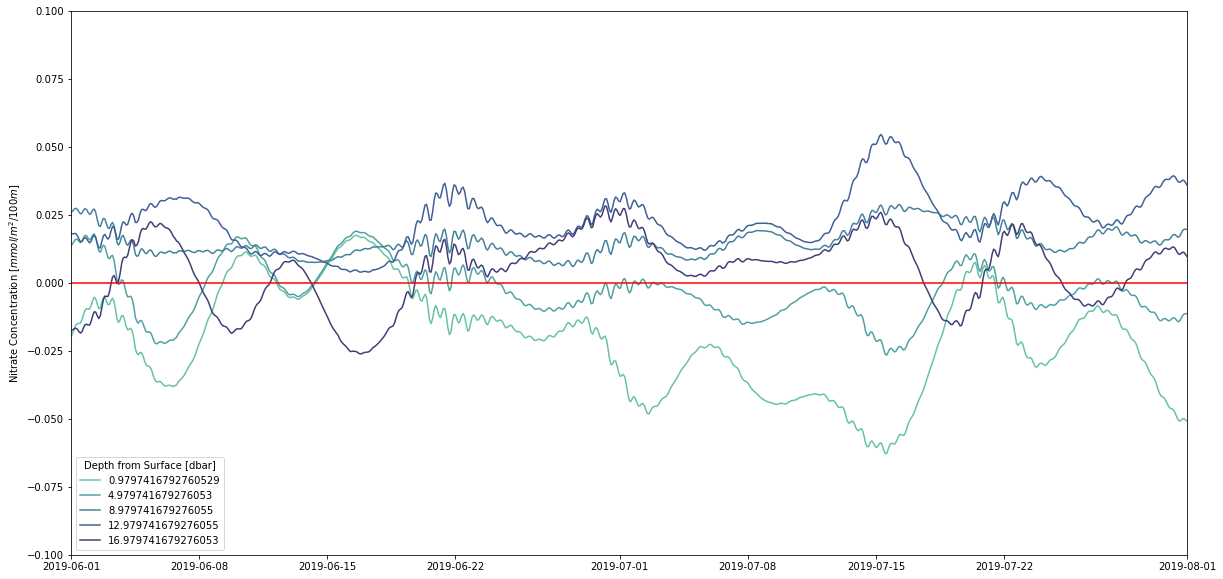

In [502]:
plt.figure(figsize=(20,10))

cdict = cm.tools.get_dict(cm.deep, N=len(nitrate_grid.T))
deep = LinearSegmentedColormap('cmap', cdict)
nfline = []
for i,nf in enumerate(nflux.T):
    nfline.append('')
    nfline[i], = plt.plot(time_grid[mask[i]],nf[mask[i]]*100,'-',color=deep(0.3+0.7*i/len(nflux.T)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [dbar]',loc=3)
plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylabel('Nitrate Flux [$mmol/s/100m$]')


plt.figure(figsize=(20,10))
cdict = cm.tools.get_dict(cm.deep, N=len(nitrate_grid.T))
deep = LinearSegmentedColormap('cmap', cdict)
nfline = []
for i,nf in enumerate(nflux.T):
    nfline.append('')
    if i%4 == 0 and pressure_grid[i] < 20:
        nfline[i], = plt.plot(time_grid[mask[i]],nf[mask[i]]*100,'-',color=deep(0.3+0.7*i/len(nflux.T)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [dbar]',loc=3)
plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylabel('Nitrate Flux [$mmol/s/100m$]')

plt.figure(figsize=(20,10))
cdict = cm.tools.get_dict(cm.deep, N=len(cs))
deep = LinearSegmentedColormap('cmap', cdict)
nfline = []
for i,n in enumerate(cs):
    nfline.append('')
    if i%4 == 0 and pressure_grid[i] < 20:
        nfline[i], = plt.plot(time_grid[vel_mask[i]],n[vel_mask[i]],'-',color=deep(0.3+0.7*i/len(cs)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [dbar]',loc=3)
plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylim([-0.1,0.1])
plt.ylabel('Nitrate Concentration [$mmol/m^2/100m$]')

Text(0, 0.5, 'Nitrate Concentration [$mmol/m^2/100m$]')

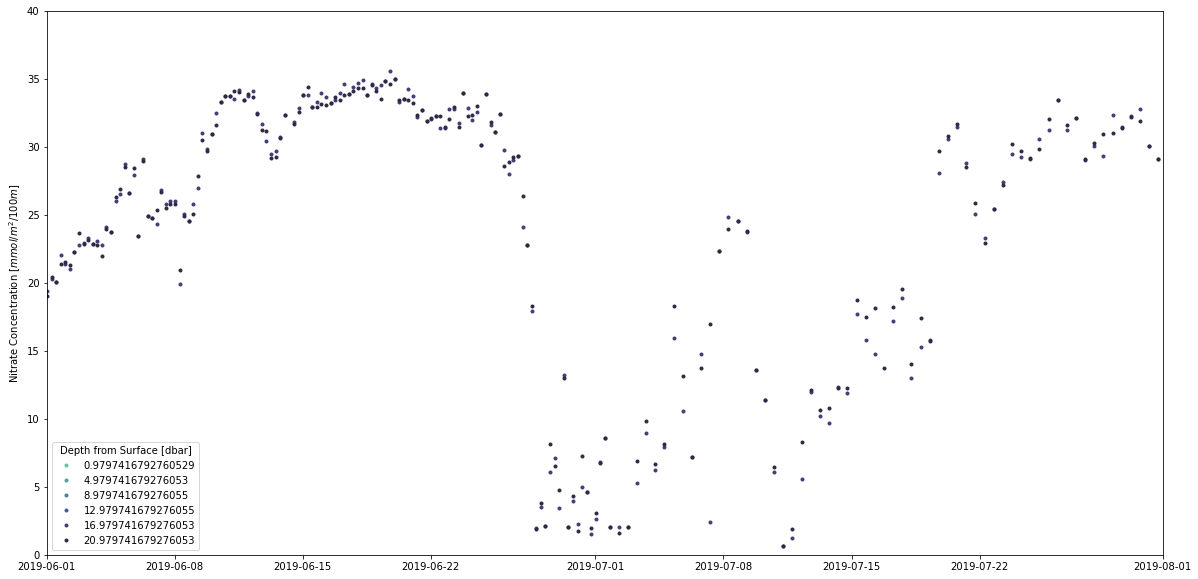

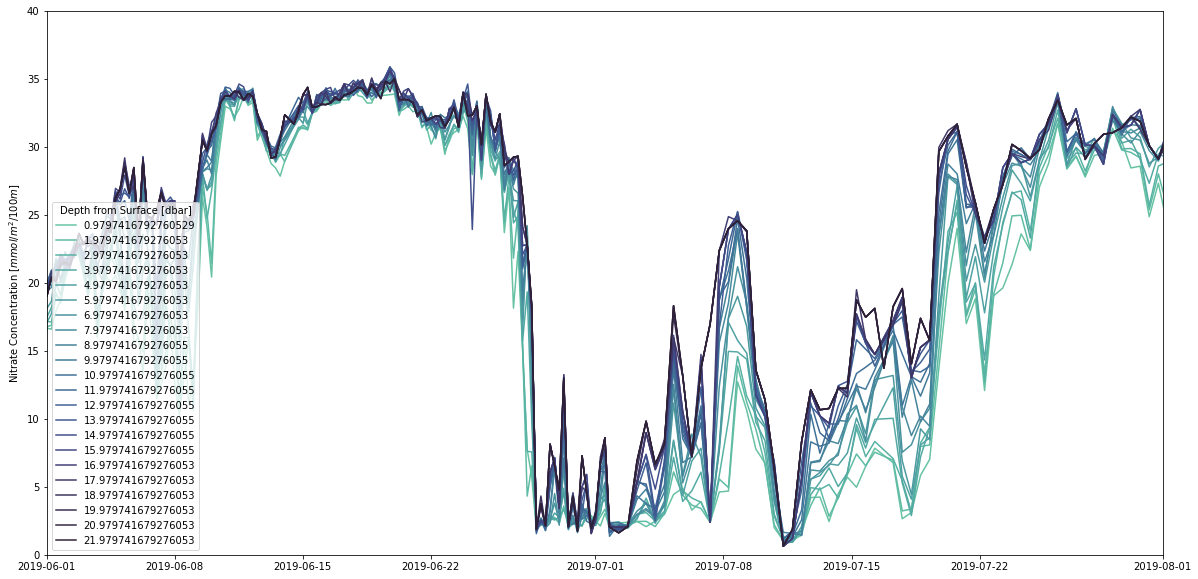

In [503]:
plt.figure(figsize=(20,10))
cdict = cm.tools.get_dict(cm.deep, N=len(nitrate_grid.T))
deep = LinearSegmentedColormap('cmap', cdict)
nfline = []
for i,n in enumerate(nitrate_grid.T):
    nfline.append('')
    if i%4 == 0:
        nfline[i], = plt.plot(time_grid[mask[i]],n[mask[i]],'.',color=deep(0.3+0.7*i/len(nflux.T)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [dbar]',loc=3)
#plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylim([0,40])
plt.ylabel('Nitrate Concentration [$mmol/m^2/100m$]')
nfline[0].set_marker(' ')
nfline[4].set_marker(' ')
nfline[8].set_marker(' ')
nfline[12].set_marker(' ')

plt.figure(figsize=(20,10))
cdict = cm.tools.get_dict(cm.deep, N=len(nitrate_grid.T))
deep = LinearSegmentedColormap('cmap', cdict)
nfline = []
for i,n in enumerate(nitrate_grid.T):
    nfline.append('')
    nfline[i], = plt.plot(time_grid[mask[i]],n[mask[i]],'-',color=deep(0.3+0.7*i/len(nflux.T)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [dbar]',loc=3)
#plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylim([0,40])
plt.ylabel('Nitrate Concentration [$mmol/m^2/100m$]')

## Surface and bottom layer nitrate fluxes and surface layer transport and depth

In [532]:
surface_flux = np.zeros(len(time_grid))
bottom_flux = np.zeros(len(time_grid))

for i,t in enumerate(time_grid):
    for j,nf in enumerate(nflux[i]):
        if ~np.isnan(nf):
            if pressure_grid[j] <= -ds['zs_comb'].values[i]:
                surface_flux[i] += nf
            elif pressure_grid[j] > -ds['zs_comb'].values[i]:
                bottom_flux[i] += nf

#replace zeroes with nan:
surface_flux[surface_flux == 0] = np.nan
bottom_flux[bottom_flux == 0] = np.nan

delta_flux = surface_flux+bottom_flux
delta_flux[delta_flux == 0] = np.nan

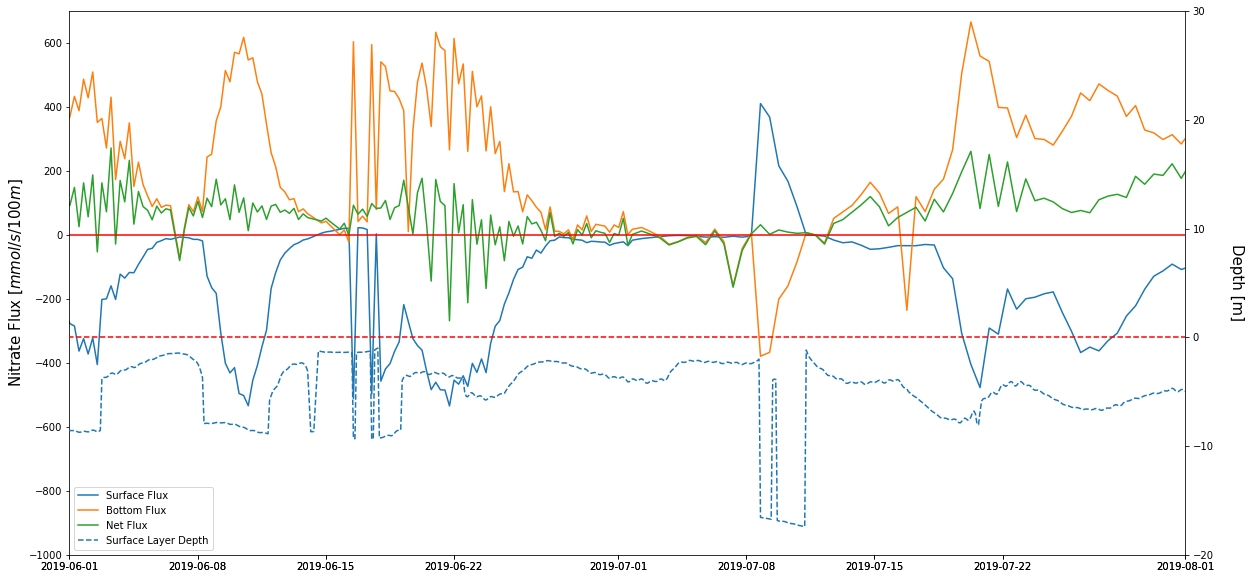

In [533]:
surf_mask = ~np.isnan(surface_flux)
bott_mask = ~np.isnan(bottom_flux)
delt_mask = ~np.isnan(delta_flux)
zs_mask = ~np.isnan(ds['zs_comb'])

nflux_label = [None]*4
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Nitrate Flux [$mmol/s/100m$]", fontsize=15)
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Depth [m]", rotation=270, labelpad=30, fontsize=15)
nflux_label[0], = (ax1.plot(time_grid[surf_mask],surface_flux[surf_mask]*100,label='Surface Flux'))
nflux_label[1], = (ax1.plot(time_grid[bott_mask],bottom_flux[bott_mask]*100,label='Bottom Flux'))
nflux_label[2], = (ax1.plot(time_grid[delt_mask],delta_flux[delt_mask]*100,label='Net Flux'))
ax1.plot(time_grid,zeros,'r')
nflux_label[3], = ax2.plot(time_grid[zs_mask],ds['zs_comb'].values[zs_mask],'--',label='Surface Layer Depth')
ax2.plot(time_grid,zeros,'r--')
plt.xlim([t1,t2])
ax1.set_ylim([-1000,700])
ax2.set_ylim([-20,30])
plt.legend(handles=nflux_label,loc=3)

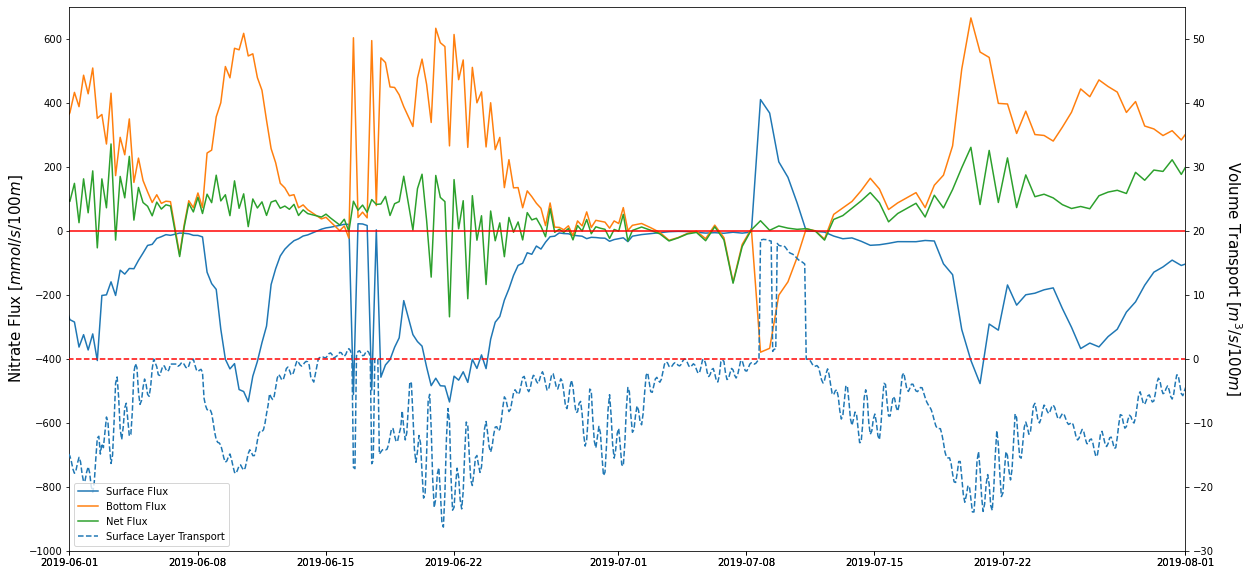

In [508]:
us_mask = ~np.isnan(ds['us_comb'])

nflux_label = [None]*4
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Nitrate Flux [$mmol/s/100m$]", fontsize=15)
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Volume Transport [$m^3/s/100m$]", rotation=270, labelpad=30, fontsize=15)
nflux_label[0], = (ax1.plot(time_grid[surf_mask],surface_flux[surf_mask]*100,label='Surface Flux'))
nflux_label[1], = (ax1.plot(time_grid[bott_mask],bottom_flux[bott_mask]*100,label='Bottom Flux'))
nflux_label[2], = (ax1.plot(time_grid[delt_mask],delta_flux[delt_mask]*100,label='Net Flux'))
ax1.plot(time_grid,zeros,'r')
nflux_label[3], = ax2.plot(time_grid[zs_mask],ds['us_comb'].values[zs_mask]*100,'--',label='Surface Layer Transport')
ax2.plot(time_grid,zeros,'r--')
plt.xlim([t1,t2])
ax1.set_ylim([-1000,700])
ax2.set_ylim([-30,55])
plt.legend(handles=nflux_label,loc=3)

(18048.0, 18109.0)

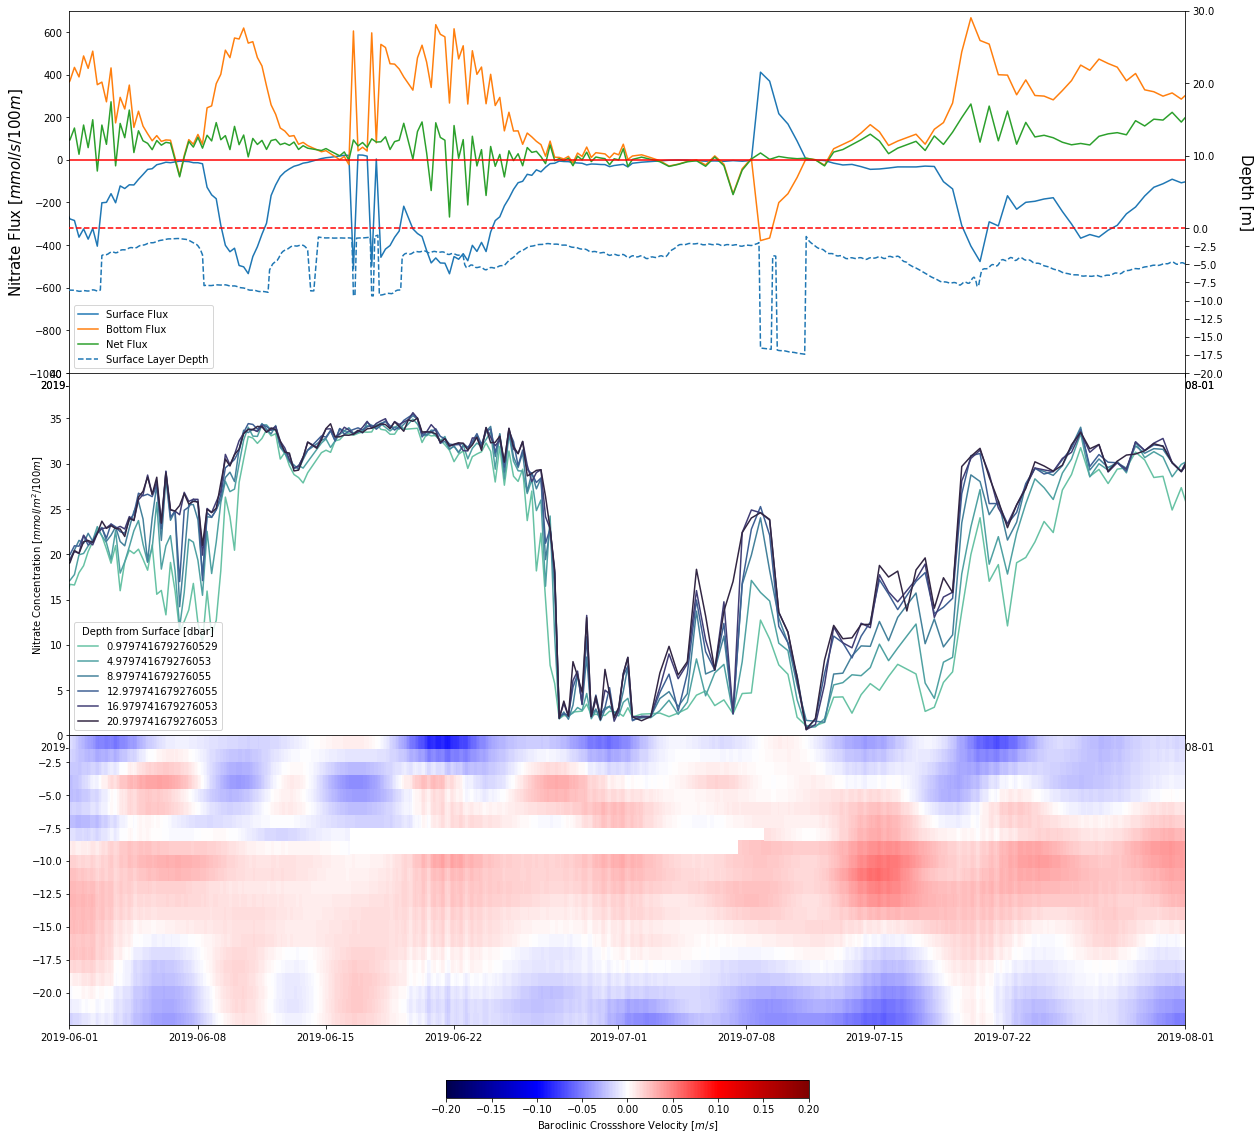

In [509]:
us_mask = ~np.isnan(ds['us_comb'])

nflux_label = [None]*4

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(311)
ax1.set_ylabel("Nitrate Flux [$mmol/s/100m$]", fontsize=15)
ax2 = fig.add_subplot(311, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Depth [m]", rotation=270, labelpad=30, fontsize=15)
nflux_label[0], = (ax1.plot(time_grid[surf_mask],surface_flux[surf_mask]*100,label='Surface Flux'))
nflux_label[1], = (ax1.plot(time_grid[bott_mask],bottom_flux[bott_mask]*100,label='Bottom Flux'))
nflux_label[2], = (ax1.plot(time_grid[delt_mask],delta_flux[delt_mask]*100,label='Net Flux'))
ax1.plot(time_grid,zeros,'r')
nflux_label[3], = ax2.plot(time_grid[zs_mask],ds['zs_comb'].values[zs_mask],'--',label='Surface Layer Depth')
ax2.plot(time_grid,zeros,'r--')
ax1.set_ylim([-1000,700])
ax2.set_ylim([-20,30])
plt.legend(handles=nflux_label,loc=3)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticks([-20,-17.5,-15,-12.5,-10,-7.5,-5,-2.5,0,10,20,30])

fig.add_subplot(312, sharex=ax1)
for i,n in enumerate(nitrate_grid.T):
    nfline.append('')
    if i%4 == 0:
        nfline[i], = plt.plot(time_grid[mask[i]],n[mask[i]],'-',color=deep(0.3+0.7*i/len(nflux.T)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [dbar]',loc=3)
#plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylim([0,40])
plt.ylabel('Nitrate Concentration [$mmol/m^2/100m$]')


fig.add_subplot(313, sharex=ax1)
pcolor = plt.pcolor(ds['time'].values,ds['bin_depths_avg'].values,
           ds['cs_bar'].values,cmap='seismic',shading='auto')
plt.clim([-0.2,0.2])
plt.colorbar(pcolor,location='bottom',orientation='horizontal',
             fraction=0.05,label='Baroclinic Crossshore Velocity [$m/s$]')
plt.subplots_adjust(wspace=0,hspace=0)

plt.xlim([t1,t2])



(18048.0, 18109.0)

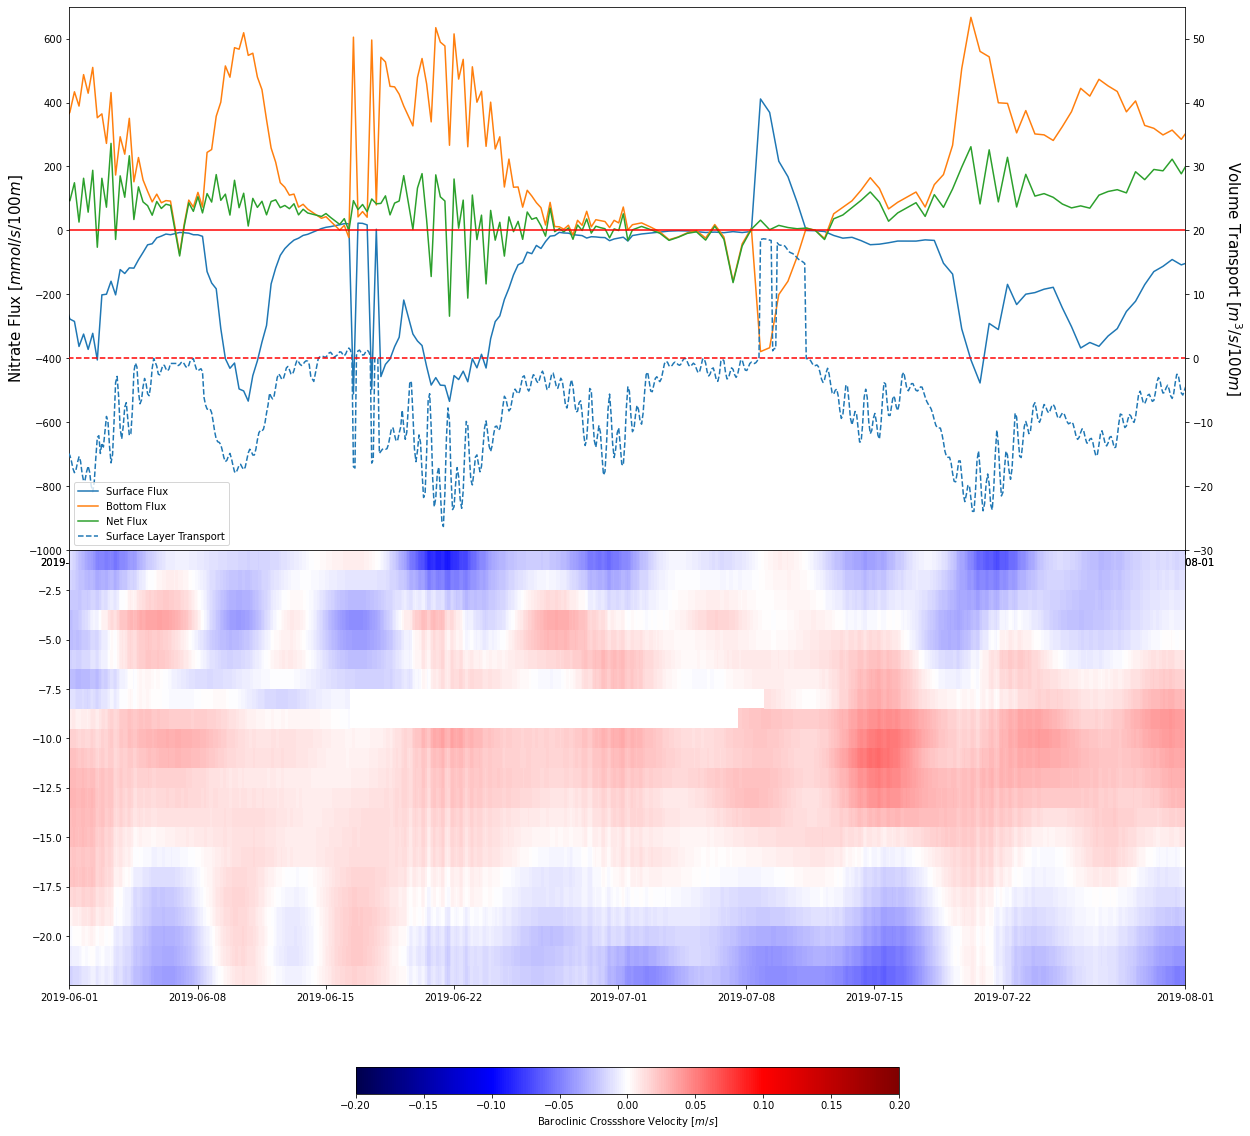

In [510]:
us_mask = ~np.isnan(ds['us_comb'])

nflux_label = [None]*4

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
ax1.set_ylabel("Nitrate Flux [$mmol/s/100m$]", fontsize=15)
ax2 = fig.add_subplot(211, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Volume Transport [$m^3/s/100m$]", rotation=270, labelpad=30, fontsize=15)
nflux_label[0], = (ax1.plot(time_grid[surf_mask],surface_flux[surf_mask]*100,label='Surface Flux'))
nflux_label[1], = (ax1.plot(time_grid[bott_mask],bottom_flux[bott_mask]*100,label='Bottom Flux'))
nflux_label[2], = (ax1.plot(time_grid[delt_mask],delta_flux[delt_mask]*100,label='Net Flux'))
ax1.plot(time_grid,zeros,'r')
nflux_label[3], = ax2.plot(time_grid[zs_mask],ds['us_comb'].values[zs_mask]*100,'--',label='Surface Layer Transport')
ax2.plot(time_grid,zeros,'r--')
ax1.set_ylim([-1000,700])
ax2.set_ylim([-30,55])
plt.legend(handles=nflux_label,loc=3)
ax1.set_xticklabels([])
ax2.set_xticklabels([])

fig.add_subplot(212, sharex=ax1)
pcolor = plt.pcolor(ds['time'].values,ds['bin_depths_avg'].values,
           ds['cs_bar'].values,cmap='seismic',shading='auto')
plt.clim([-0.2,0.2])
plt.colorbar(pcolor,location='bottom',orientation='horizontal',
             fraction=0.05,label='Baroclinic Crossshore Velocity [$m/s$]')
plt.subplots_adjust(wspace=0,hspace=0)

plt.xlim([t1,t2])

In [519]:
vflux = np.nan*np.empty([len(ds['time'].values),len(ds['bin_depths_avg'].values)])

#rectangle widths for riemann sum
dz = np.nan*np.empty(len(pressure_grid))
for i,pg in enumerate(pressure_grid):
    dz[i] = pressure_bins[i+1] - pressure_bins[i] #find height of each bin

    
for i in range(len(ds['time'])):
    for j in range(len(ds['bin_depths_avg'])):
        #leave nan values as nan in case they do not match up b/t cs and nit
        #if not np.isnan(nitrate_grid[i][j]) & np.isnan(cs_bar[i][j]):
            #nitrate flux in mmol/s/meter coastline
        vflux[i][j] = ds['cs_bar'].values.T[i][j] * dz[j]
        #test to make sure this works for sea surface transport too:

ustest = np.zeros(len(time_grid))
        
for i,t in enumerate(time_grid):
    for j,vf in enumerate(vflux[i]):
        if ~np.isnan(vf):
            if pressure_grid[j] <= -ds['zs_comb'].values[i]:
                ustest[i] += vf
                #print(-ds['zs_comb'].values[i])

In [520]:
vflux_upd = np.nan*np.empty([len(ds['time'].values),len(ds['bin_depths_avg'].values)])

#rectangle widths for riemann sum
dz = np.nan*np.empty(len(pressure_grid))
for i,pg in enumerate(pressure_grid):
    dz[i] = pressure_bins[i+1] - pressure_bins[i] #find height of each bin

    
for i in range(len(ds['time'])):
    for j in range(len(depth)):
        #leave nan values as nan in case they do not match up b/t cs and nit
        #if not np.isnan(nitrate_grid[i][j]) & np.isnan(cs_bar[i][j]):
            #nitrate flux in mmol/s/meter coastline
        vflux_upd[i][j] = cs_bar[j][i] * dz[j]
        #test to make sure this works for sea surface transport too:

ustest_upd = np.zeros(len(time_grid))
        
for i,t in enumerate(time_grid):
    for j,vf in enumerate(vflux_upd[i]):
        if ~np.isnan(vf):
            if pressure_grid[j] <= -ds['zs_comb'].values[i]:
                ustest_upd[i] += vf

(-0.3, 0.3)

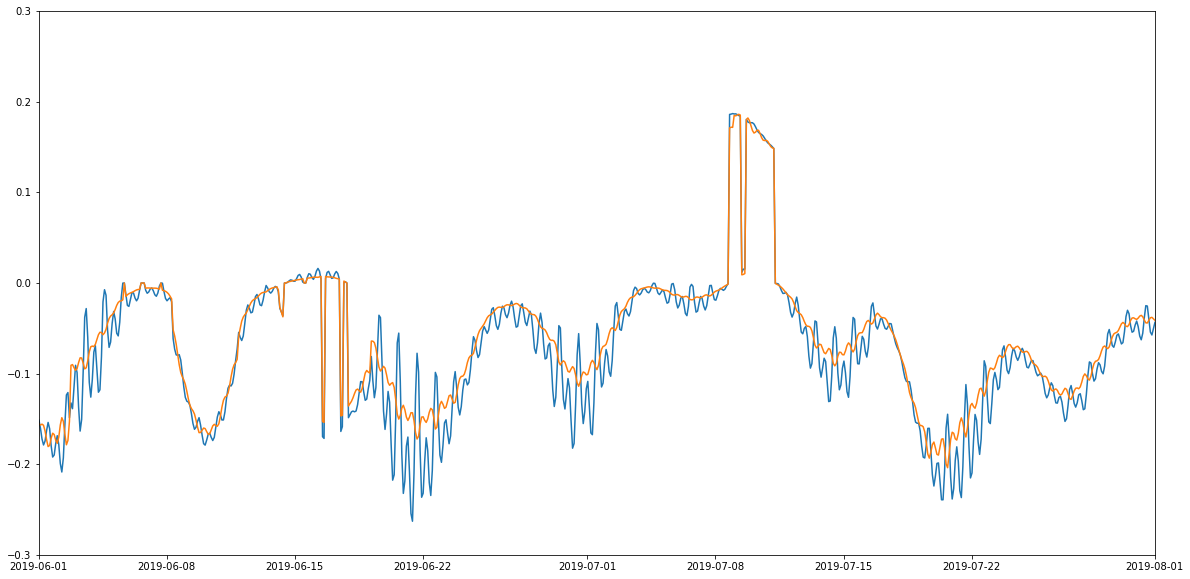

In [521]:
plt.figure(figsize=(20,10))
plt.plot(time_grid,ds['us_comb'])
plt.plot(time_grid,ustest_upd)
plt.xlim([t1,t2])
plt.ylim([-0.3,0.3])

In [522]:
surface_flux_pho,zero_cross_flux = ts.surface_flux(cs_bar.T, -pressure_grid, nitrate_grid, ds['sea_surface'].values)

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\physoce-0.0.2-py3.9.egg\physoce\tseries.py:680: RuntimeWarning: All-NaN slice encountered
  badi, = np.where(np.isnan(np.nanmax(xm,axis=1)))


In [523]:
surface_flux_pho

array([nan, nan, nan, ..., nan, nan, nan])

In [524]:
#empty array for nitrate flux data
nflux = np.nan*np.empty([len(nitrate_grid),len(nitrate_grid.T)])

#rectangle widths for riemann sum
dz = np.nan*np.empty(len(pressure_grid))
for i,pg in enumerate(pressure_grid):
    dz[i] = pressure_bins[i+1] - pressure_bins[i] #find height of each bin

for i in range(len(nitrate_grid)):
    for j in range(len(nitrate_grid.T)):
        #leave nan values as nan in case they do not match up b/t cs and nit
        #if not np.isnan(nitrate_grid[i][j]) & np.isnan(cs_bar[i][j]):
            #nitrate flux in mmol/s/meter coastline
        nflux[i][j] = nitrate_grid[i][j] * cs_bar[j][i] * dz[j]
        #test to make sure this works for sea surface transport too:
        
surface_flux = np.zeros(len(time_grid))
bottom_flux = np.zeros(len(time_grid))

for i,t in enumerate(time_grid):
    for j,nf in enumerate(nflux[i]):
        if ~np.isnan(nf):
            if pressure_grid[j] <= -ds['zs_comb'].values[i]:
                surface_flux[i] += nf
            elif pressure_grid[j] > -ds['zs_comb'].values[i]:
                bottom_flux[i] += nf

delta_flux = surface_flux+bottom_flux

In [525]:
surface_flux[surface_flux == 0] = np.nan
surface_flux_pho[surface_flux_pho == 0] = np.nan

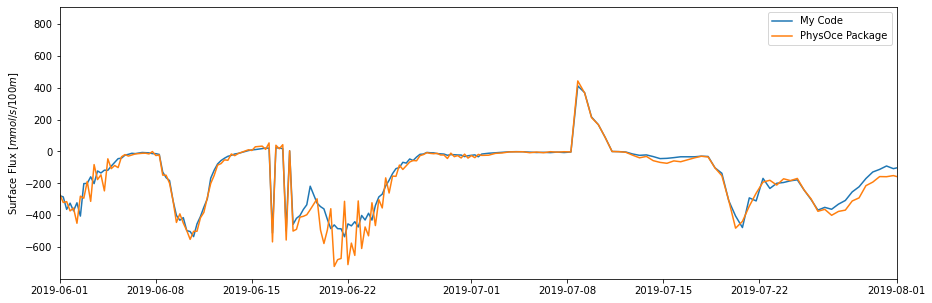

In [526]:
mask_surf =  ~np.isnan(surface_flux)
mask_pho = ~np.isnan(surface_flux_pho)

plt.figure(figsize=(15,5))
plt.plot(time_grid[mask_surf], surface_flux[mask_surf]*100,'-',label='My Code')
plt.plot(time_grid[mask_pho], surface_flux_pho[mask_pho]*100,'-',label='PhysOce Package')
plt.xlim([t1,t2])
plt.ylabel('Surface Flux [$mmol/s/100m$]')
plt.legend()

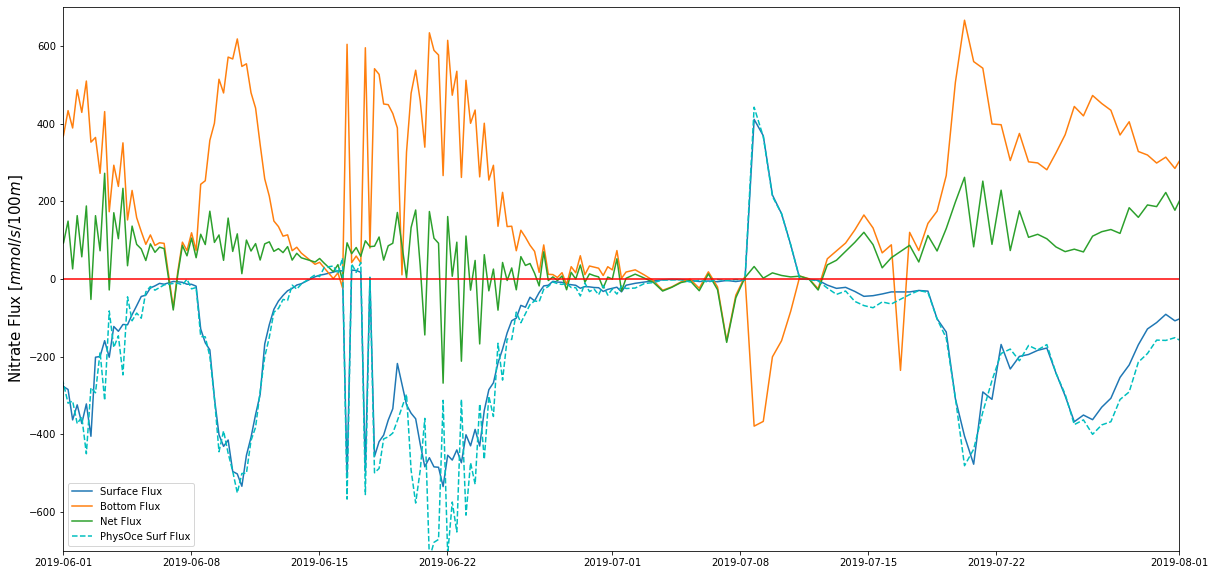

In [537]:
nflux_label = [None]*4
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Nitrate Flux [$mmol/s/100m$]", fontsize=15)
#ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.set_ylabel("Volume Transport [$m^3/s/100m$]", rotation=270, labelpad=30, fontsize=15)
nflux_label[0], = (ax1.plot(time_grid[mask_surf],surface_flux[surf_mask]*100,label='Surface Flux'))
nflux_label[1], = (ax1.plot(time_grid[bott_mask],bottom_flux[bott_mask]*100,label='Bottom Flux'))
nflux_label[2], = (ax1.plot(time_grid[delt_mask],delta_flux[delt_mask]*100,label='Net Flux'))
nflux_label[3], = (ax1.plot(time_grid[mask_pho],surface_flux_pho[mask_pho]*100,'--c',label='PhysOce Surf Flux'))
ax1.plot(time_grid,zeros,'r')
#ax2.plot(time_grid,zeros,'r--')
plt.xlim([t1,t2])
ax1.set_ylim([-700,700])
ax2.set_ylim([-30,55])
plt.legend(handles=nflux_label,loc=3)

In [ ]:
#another way of getting net nitrate flux: 
#take depth average of vel multiplied by nitrate concentration, then multiply by depth